# 용어사전으로 MCQA 데이터를 생성하는 예제

## <span style="color: #886CE4"> 1. 시사경제용어사전 읽어오기 </span>

[Link](https://www.econedu.go.kr/user/playEcon/currEconTermDoc/menu/listhttps://www.econedu.go.kr/user/playEcon/currEconTermDoc/menu/list)를 통해 용어집 엑셀 파일을 다운로드하고, `reference_samples` 폴더에 저장합니다.

In [7]:
import pandas as pd
reference = "reference_samples/시사경제용어.xlsx"
df = pd.read_excel(reference)

In [8]:
df.head(5)

,순번,주제,용어,설명
0,1,사회,0.5인 가구,싱글족 가운데 두 곳 이상에 거처를 두거나 잦은 여행과 출장 등으로 오랫동안 집을 ...
1,2,경영,1인 창조기업,"개인이 사장이면서 직원인 기업을 의미한다. 자신이 가진 '지식, 경험, 기술' 등을..."
2,3,경제,1인당 국민소득,국민소득을 총국민 수로 나눈 값. 해당 국가의 소득 수준을 보여주는 가장 대표적인 ...
3,4,과학,20-20-20 계획,"\t유럽연합(EU)이 2020년까지 온실가스 20% 감축, 에너지효율 20% 개선,..."
4,5,금융,2차 시장(Secondary Market),"2차 시장은 처음 발행된 증권, 채권 등이 거래되는 발행시장과 구분되며, 이미 발행..."


## <span style="color: #886CE4"> 2. Input Data로 변형하기 </span>
PDF를 파싱하는 것과 달리, 용어사전의 경우는 이미 검수가 끝난 좋은 Quality의 데이터 입니다.  
따라서 `quality_filter`를 적용할 필요없이 Graph Pipeline의 Input Data형태로 변형해주면 됩니다.  
Graph Pipeline의 Input은 Json line 형태여야 하며, `title`과 `contents`를 포함해야 합니다.  

In [11]:
df.head(1)

,순번,주제,용어,설명
0,1,사회,0.5인 가구,싱글족 가운데 두 곳 이상에 거처를 두거나 잦은 여행과 출장 등으로 오랫동안 집을 ...


In [12]:
# 용어는 title로, 설명은 contents로 바꿔줍니다.
df = df.rename({"용어": "title", "설명": "contents"}, axis = 1)

In [13]:
df.head(1)

,순번,주제,title,contents
0,1,사회,0.5인 가구,싱글족 가운데 두 곳 이상에 거처를 두거나 잦은 여행과 출장 등으로 오랫동안 집을 ...


In [14]:
# to_dict 함수로 Json line 형태로 바꿔줍니다.
data = df.to_dict("records")
data[:2]

[{'순번': 1,
  '주제': '사회',
  'title': '0.5인 가구',
  'contents': '싱글족 가운데 두 곳 이상에 거처를 두거나 잦은 여행과 출장 등으로 오랫동안 집을 비우는 사람들을 일컫는 말. 0.5인 가구는 1인 가구보다 집에 머무는 시간이 훨씬 더 짧다. 평소에는 직장 근처에 방을 얻어 혼자 살지만 주말에는 가족들의 거처로 찾아가 함께 시간을 보내는 경우도 여기에 속한다.'},
 {'순번': 2,
  '주제': '경영',
  'title': '1인 창조기업',
  'contents': "개인이 사장이면서 직원인 기업을 의미한다. 자신이 가진 '지식, 경험, 기술' 등을 사용하여 보다 창조적인 서비스를 제공함으로써 이윤을 창출하는 경우 1인 창조기업이라 할 수 있다. 구체적으로는 △소프트웨어 개발, 홈페이지 제작 등 IT서비스 △만화, 드라마, 영화제작 등 문화콘텐츠 서비스 △전통식품, 공예품 분야의 제조업 등 창의적인 아이디어나 전문 지식ㆍ기술 등 분야의 1인 중심기업을 말한다."}]

## <span style="color: #886CE4"> 3. MCQA graph Pipeline </span>
MCQA Graph Pipepline을 통해서 Instruction 데이터셋을 생성합니다.
데이터 생성 전에 GPT의 API를 사용해야하므로 `api_key`를 환경설정에 추가합니다.

```python
os.environ['OPENAI_API_KEY'] = 'sk-....'
```

MCQA Graph Pipeline은 설정값을 전달해야합니다.
`utils.graph.mcqa_graph`의 docstring에는 아래와 같이 제공되어 있습니다.  

```python
data = pd.DataFrame(read_jsonl("sisa_encyc.jsonl"))
data = make_index(data.to_dict("records"), prefix="시사경제용어사전")
inputs = {
    "save_dir": ".", # 저장할 디렉토리명
    "save_file_name": "sisa_encyc", # 저장할 파일명.
    "task_type": "common", # common, knowledge, math
    "eval_type": "mcqa", # mcqa, qa
    "domain_type": "common", # common, market, accounting, law, quant
    "n_datasets": 5, # Step별로 Refence당 생성할 MCQA 데이터셋 수
    "max_step": 2, # 몇 Step까지 실행할 것인지
    "n_workers": 300, # GPT로 생성시 Concurrent의 Worker 수
    "oai_model": "gpt-4o-mini", # gpt 모델명. Dictionary 타입으로 각 completion마다 정의 가능
    "error_tolerance_ratio": 0.03, # 허용할 에러율. 해당 에러율 이하로 에러 발생시 다음 단계로 진행
    "show_log_error": False, # 에러별로 발생한 Index를 로그로 표시
    "data": data # Reference 데이터
}
graph = mcqa_graph()
result = graph.invoke(inputs=inputs, config={"recursion_limit": 30}) # Graph에서 재귀적으로 실행되는 허용치
```

Graph Pipe Line들에 입력되는 data들은 모두 Jsonline 형태여야 하며, `title`과 `contents`가 포함되어야 합니다.  
또한 graph에 투입되기 전, `utils.processing.make_index`함수로 인덱스를 생성해줘야합니다.  
이때 생성한 index를 기반으로 graph 내에서 에러 처리를 수행합니다.

In [15]:
from utils import make_index, mcqa_graph

# 우리가 생성한 'data'도 json line형태이므로 따로 read_jsonl로 읽을 필요는 없습니다.
data = make_index(data, prefix="시사경제용어") 

In [16]:
data[23]

{'순번': 24,
 '주제': '경영',
 'title': 'ASP(Application Service Provider)',
 'contents': '네트워크를 통해 기업의 핵심 Business Application을 제공하고, 전문기술인력이 이를 구축, 관리해주는 새로운 개념의 IT 서비스이다. 즉, 고가의 하드웨어, 소프트웨어를 도입하지 않고도 네트워크 인프라를 이용하여 다양한 정보화 솔루션을 사용할 수 있는 애플리케이션 임대 서비스이다. 기존의 애플리케이션 소프트웨어를 패키지화하여 판매하는 방식이 아닌, 웹을 통해 일정 비용만 내고 빌려 쓸 수 있는 애플리케이션 아웃소싱의 개념이다. 기업 혹은 개인의 입장에서는 별도의 서버 혹은 애플리케이션을 구매 하지 않아도 되어 비용, 시간, 관리 인력 부담의 해소가 가능하다. 중소기업의 경우, 선진 경영 및 업무 프로세스를 쉽게 취득하면서 대기업과 동등한 업무혁신이 가능하다는 점이 장점이다. 온 디맨드(On-demand) 또는 사스(SaaS: Software as a Service)라고도 일컫는다.',
 'index': '시사경제용어_23'}

In [17]:
# 샘플로 10개의 data만 MCQA graph pipeline으로 생성
data = data[:10]

inputs = {
    "save_dir": ".", # 저장할 디렉토리명
    "save_file_name": "sisa_economy_terms", # 저장할 파일명.
    "task_type": "common", # common, knowledge, math
    "eval_type": "mcqa", # mcqa, qa
    "domain_type": "common", # common, market, accounting, law, quant
    "n_datasets": 2, # Step별로 Refence당 생성할 MCQA 데이터셋 수
    "max_step": 1, # 몇 Step까지 실행할 것인지
    "n_workers": 300, # GPT로 생성시 Concurrent의 Worker 수
    "oai_model": "gpt-4o-mini", # gpt 모델명. Dictionary 타입으로 각 completion마다 정의 가능
    "error_tolerance_ratio": 0.3, # 허용할 에러율. 해당 에러율 이하로 에러 발생시 다음 단계로 진행
    "show_log_error": False, # 에러별로 발생한 Index를 로그로 표시
    "data": data # Reference 데이터
}
graph = mcqa_graph()
result = graph.invoke(input=inputs, config={"recursion_limit": 30}) # Graph에서 재귀적으로 실행되는 허용치

2024-12-10 00:56:04.513 | INFO     | utils.graph:node_generate_mcqa_step_1:93 - **State Parameters**
save_dir: .
save_file_name: sisa_economy_terms
task_type: common
eval_type: mcqa
domain_type: common
n_datasets: 2
n_workers: 300
max_step: 1
oai_model: gpt-4o-mini
error_tolerance_ratio: 0.3
2024-12-10 00:56:04.514 | INFO     | utils.graph:node_generate_mcqa_step_1:95 - node_generate_mcqa_step_1
2024-12-10 00:56:04.514 | INFO     | utils.utils:concurrent_execute:104 - n_workers: 300
2024-12-10 00:56:04.514 | INFO     | utils.utils:concurrent_execute:105 - iterables length: 10
100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]
2024-12-10 00:56:20.995 | INFO     | utils.graph:node_process_mcqa_errors:260 - node_process_mcqa_errors
2024-12-10 00:56:20.997 | INFO     | utils.graph:node_process_mcqa_errors:271 - Option Errors:[](0)
2024-12-10 00:56:20.999 | INFO     | utils.graph:node_process_mcqa_errors:277 - Answer Erro

Langgraph에서 [graph는 시각화](https://langchain-ai.github.io/langgraph/how-tos/visualization/)할 수 있습니다.  
`utils.graph.show_graph`는 생성한 graph를 시각화해주고, `utils.graph.save_graph`는 png파일 형태로 저장합니다.

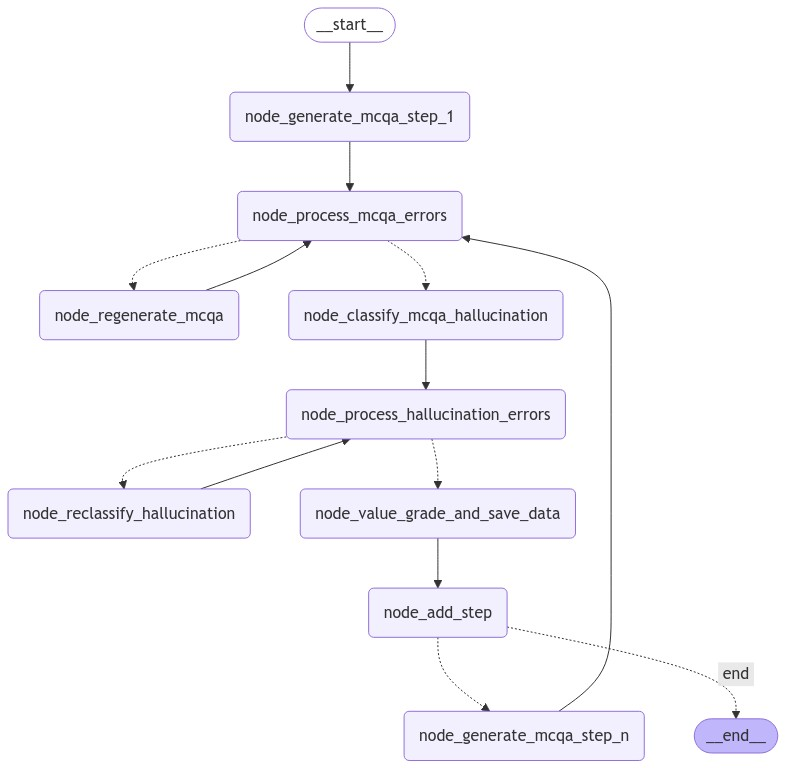

In [18]:
from utils import show_graph

show_graph(graph)

## <span style="color: #886CE4"> 4. Sample Check </span>
파이프라인은 지정한 Path에 Json line 형태로 저장합니다.  
생성한 데이터셋을 Pandas DataFrame으로 읽어봅니다.

In [19]:
from utils import read_jsonl
import pandas as pd

df = pd.DataFrame(read_jsonl("./sisa_economy_terms_common_mcqa_common_step_1.jsonl"))

2024-12-10 00:57:05.638 | INFO     | utils.io:read_jsonl:142 - read jsonl file in ./sisa_economy_terms_common_mcqa_common_step_1.jsonl


In [20]:
# 생성한 Instruction 데이터셋 확인
df.head(1)

,index,title,contents,question,options,reasoning_process,answer,step,hallucination,hallucination_desc,value,type,oai_model,update_at
0,시사경제용어_3,20-20-20 계획,"\t유럽연합(EU)이 2020년까지 온실가스 20% 감축, 에너지효율 20% 개선,...","유럽연합(EU)의 20-20-20 계획에 따르면, 2020년까지 온실가스 감축 목표...","[A. 30%, B. 15%, C. 25%, D. 20%, E. 10%]",EU의 20-20-20 계획은 2020년까지 온실가스 감축 목표를 20%로 설정하여...,D,1,usable,,0,mcqa,gpt-4o-mini,2024-12-10


`utils.processing.show_sample`과 `utils.processing.show_spec`은 데이터를 시각화한데 도움을 줍니다.

In [21]:
from utils import show_sample, show_spec

# show_sample은 Pandas DataFrame을 Parameter로 받으며, 샘플을 보기 좋게 시각화해줍니다.
show_sample(df, n=2)

5번째 Sample
question:
현재 3D TV를 시청하기 위해 필요한 것은 무엇인가요?
options:
A. 특별한 사운드 시스템
B. 고해상도 모니터
C. 전기 유도 장치
D. 스마트폰과의 연결
E. 3D 전용 안경
reasoning_process:
현재 3D TV를 정상적으로 시청하기 위해서는 시청자가 3D 전용 안경을 착용해야 합니다. 이는 3D 기술의 특성상 각 눈에 다른 이미지를 전달하기 위하여 필수적인 요소입니다. 그러므로 정답은 3D 전용 안경입니다. 위에서 논의한 바와 같이 답은 E 입니다.
answer:
E
hallucination:
usable

value:
0
6번째 Sample
question:
다음 중 3층 연금체계에 대한 설명으로 맞는 것은 무엇인가?
options:
A. 3층 연금체계는 정부가 강제 적용하는 기초연금 성격의 공적연금으로 시작된다.
B. 3층 연금체계는 기본적으로 공적연금만으로 구성된다.
C. 3층 연금체계는 민간이 연금 운영을 전혀 하지 않는다.
D. 3층 연금체계는 공적연금과 사적연금이 독립적으로 존재한다.
E. 3층 연금체계는 노후 소득 보장을 위해 기본적으로 사적연금만으로 이루어진다.
F. 3층 연금체계의 첫 번째 층은 개인이 선택적으로 가입하는 개인연금이다.
G. 3층 연금체계는 1층에 국민연금, 2층에 퇴직금, 3층에 개인연금을 포함한다.
reasoning_process:
3층 연금체계에서는 각 층의 역할이 매우 중요합니다. 1층은 기초연금적인 성격을 띠고 있으며, 이는 국민연금과 직역연금으로 구분됩니다. 따라서 1층의 특성을 고려했을 때, 정부가 강제로 적용함으로써 노후 소득의 기본 보장을 합니다. 2층은 기업에서 제공하는 퇴직금 또는 직역연금을 포함하여 민간에서 운용되지만 강제성이 있다는 점에서 중요한 역할을 합니다. 마지막으로 3층은 민간에서 임의적으로 가입할 수 있는 개인연금으로, 주로 개인의 선택에 따라 운영됩니다. 따라서 3층 연금체계가 정부가 강제적으로 운영하는 기초연금으로 시작한다는 점이

In [22]:
# show_spec은 특정 컬럼의 count를 확인시켜줍니다
show_spec(df, "value")

total cnt: 14
value: [0, 4, 1, 5, 2, 3]
0: 3
1: 6
2: 1
3: 2
4: 1
5: 1
